<a href="https://colab.research.google.com/github/sachinkun21/Bayesian_Change_Point/blob/master/BCP_Tryout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Bayesian Changepoint Model
The Bayesian Changepoints model scores changepoint probability in a univariate sequential dataset, usually a time series.

**Changepoint:** Changepoints are abrupt changes in the mean or variance of a time series. For instance, during an economic recession, stock values might suddenly drop to a very low value. The time at which the stock value dropped is called a changepoint.

The Bayesian Changepoints model has two variants:
1. Bayesian Offline Changepoint Detection [https://arxiv.org/pdf/0910.3099.pdf]
2. Bayesian Online Changepoint Detection [https://arxiv.org/pdf/0710.3742v1.pdf]



In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from __future__ import division

# uncomment this if not installed 
# !pip install bayesian_changepoint_detection  

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [0]:
def generate_normal_time_series(distributions ,  minl = 50 , maxl= 5000):
    
    # intialising blank array to store genrated data
    data = np.array([], dtype = np.float64)
    
    # generating count of datapoints for each value in (0,num) to generate normal distributions
    partition = np.random.randint(minl, maxl,distributions)
    
    # generating datapoints for 
    for datapoints in partition:
        # mean and variance for each distribution
        mean = np.random.randn()*10
        var = np.random.randn()*1
        
        # converting negative variance value to positive
        if var<0:
            var *= -1
            
        # using the mean and varince generated above to create Normal Distribution
        tdata = np.random.normal(mean,var,datapoints )
        
        # appending the distribution into data array
        data =  np.concatenate((data, tdata))
    
    # returning data array 
    return data
        
            

In [0]:
# calling the function
data = generate_normal_time_series(6, 100, 300)
data[:5]

array([4.91104077, 4.26709164, 4.73905893, 4.61595237, 5.12565003])

So the data has been generated.
Let's take a look at the Line Plot and Verify that there are indeed 10 distinct distributions in data 

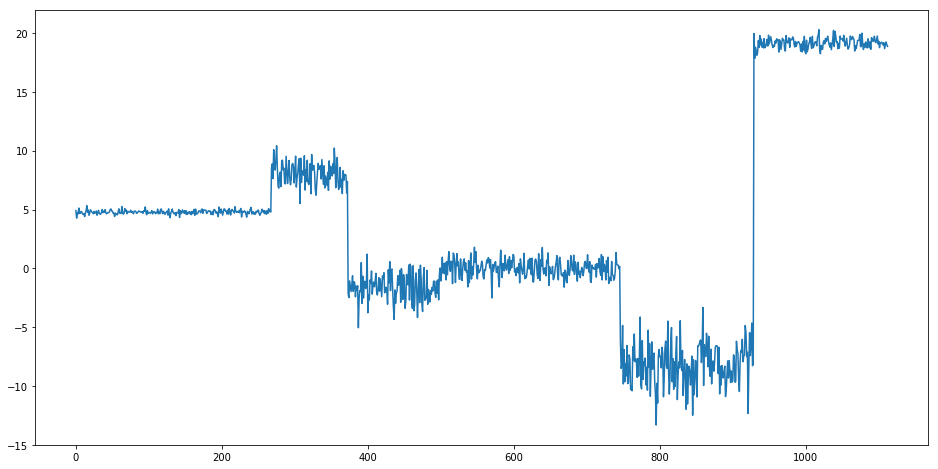

In [0]:
fig, ax = plt.subplots(figsize=[16, 8])
ax.plot(data)
plt.show()


Also, before we proceed and perform BCP on our Pseudo Data, let's understand what's a partial fucntion which will be used for passing the value of parameter in BCP.
#### **Partial function** 
Partial functions allow one to derive a function with x parameters to a function with fewer parameters and fixed values set for the more limited function.

In [1]:
# The following code will return 8
from functools import partial

def multiply(x,y):
        return x * y

# create a new function that multiplies by 2
dbl = partial(multiply,2)
print(dbl(4))

8


### **Offline Changepoint Detection**
Lets compute the probability of changepoints at each time step. We need two things for that.
- First a prior of how probable is it to have two successive changepoints with the distance t. 
- The second thing is a model of the likelihood of data in a sequence [s, t] of the data, given that in this sequence there is no changepoint.

For this example we assume a uniform prior over the length of sequences (const_prior) and a piecewise gaussian model (gaussian_obs_log_likelihood).



In [0]:
import bayesian_changepoint_detection.offline_changepoint_detection as offcd
from functools import partial


Q, P, Pcp = offcd.offline_changepoint_detection(data, 
                                                partial(offcd.const_prior, l = len(data)+1), 
                                                offcd.gaussian_obs_log_likelihood, truncate = -40) 


Use scipy logsumexp().


#### The offline_changepoint_detection() function returns three things:
- Q[t], the log-likelihood of data [t, n]
- P[t, s], the log-likelihood of a datasequence [t, s]
- Given there is no changepoint between t and s and Pcp[i, t], the log-likelihood that the i-th changepoint is at time step t. 

To actually get the probability of a changepoint at time step t we can sum the Pcp probabilities.

**Now let's see how it looks like for our generated data:**

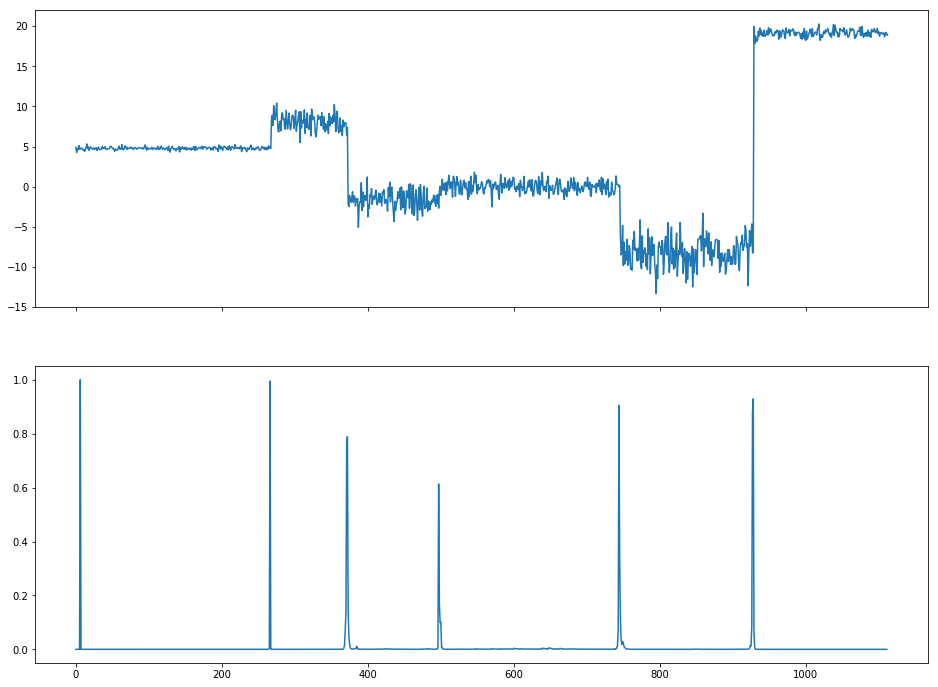

In [0]:
fig , ax = plt.subplots(2, sharex = True, figsize = (16, 12))

ax[0].plot(data)
ax[1].plot(np.exp(Pcp).sum(0))

plt.show()

### Online Changepoint Detection
Let's assume the data points come in one after another and not as these nice batches. During the process you want to know if the new point has the same hyperparameter or different ones. You need an online changepoint detection.

The online version computes slightly different things. For each time step it returns the probability distribution over the length of the last sequence. E.g. R[7, 3] is the probability at time step 7 that the last sequence is already 3 time steps long. It also returns the MAP estimate at each timestep for convenience.
 
It is called online due to the fact that it operates by reading one data point at a time and providing estimates of the likelihood of a changepoint at a given time based only on information up to that point in time.

The steps of the Online algorithm are explained  below:

**Step 1: ** Observe new datum xt and evaluate the likelihood of seeing this value for each possible run length. This is a probability vector, with an element for all possible run lengths. This algorithm assumes a Gaussian distribution between each pair of changepoints.

![image.png](attachment:image.png)


**Step 2: ** For each possible run length r>0 at current time t, calculate the probability of growth. expected_runlength is a parameter describing the a-priori best guess of run length. The larger expected_runlength is, the stronger the evidence must be in the data to support a high changepoint probability.

![image2.png](attachment:image.png)

**Step 3: ** Calculate probability of change, or r=0.

![image3.png](attachment:image.png)
                    


**Step 4: ** Normalize the probability. For all run length probabilities at time t, divide by the sum of all run length probabilities.

![image.png](attachment:image.png)
                    
**Step 5: ** For each incoming point, repeat this process. This per-point update is why the method is considered an online learning algorithm.

The output of this model is a probability distribution of run lengths for each point in the training data

In [0]:
import bayesian_changepoint_detection.online_changepoint_detection as oncd

R, maxes = oncd.online_changepoint_detection(data,
                                             partial(oncd.constant_hazard, 250), 
                                             oncd.StudentT(0.1, .01, 1, 0))


**Note: ** Since it's very difficult to correctly evaluate a change after a single sample of a new distribution, we instead can "wait" for N samples and evalute the probability of a change happening N samples prior (N = 10 in the implementation given below).

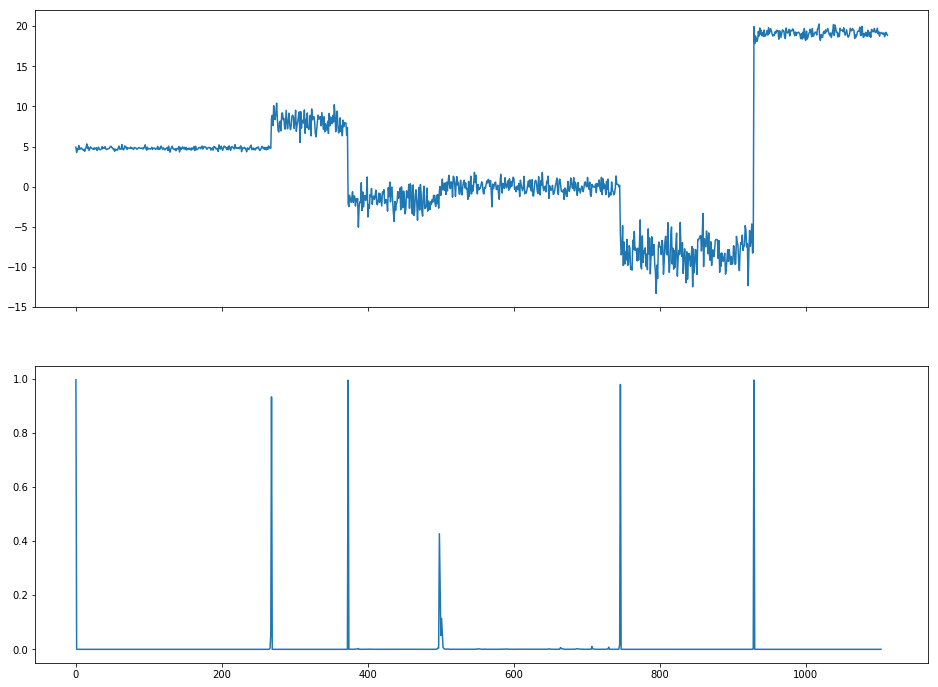

In [0]:
fig , ax = plt.subplots(2, sharex = True, figsize = (16, 12))

ax[0].plot(data)
ax[1].plot(R[10, 10:])

plt.show()

To plot the distributions we use a grey-scale colormap, black is zero, white 1. We also plot the probability at each time step for a sequence length of 0, i.e. the probability of the current time step to be a changepoint.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


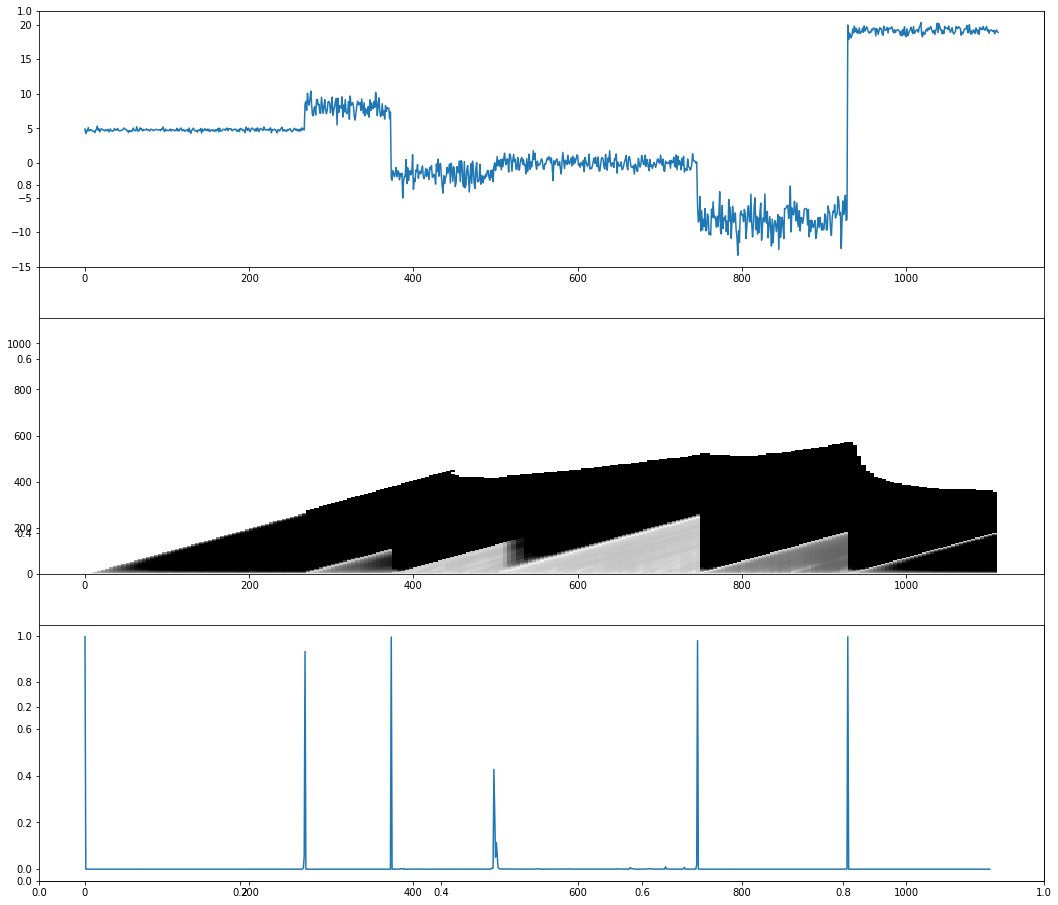

In [0]:
import matplotlib.cm as cm
fig, ax = plt.subplots(figsize=[18, 16])
ax = fig.add_subplot(3, 1, 1)
ax.plot(data)
ax = fig.add_subplot(3, 1, 2, sharex=ax)
sparsity = 5  # only plot every fifth data for faster display
ax.pcolor(np.array(range(0, len(R[:,0]), sparsity)), 
          np.array(range(0, len(R[:,0]), sparsity)), 
          -np.log(R[0:-1:sparsity, 0:-1:sparsity]), 
          cmap=cm.Greys, vmin=0, vmax=30)
ax = fig.add_subplot(3, 1, 3, sharex=ax)
Nw=10;
ax.plot(R[Nw,Nw:-1])

### Performace comparison:
Let's compute the time taken by each method on same dataset and evaluate the performance:

In [0]:
%timeit Q, P, Pcp = offcd.offline_changepoint_detection(data,  partial(offcd.const_prior, l = len(data)+1), offcd.gaussian_obs_log_likelihood, truncate = -40) 

45.3 s ± 736 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [0]:
%timeit R,maxes = oncd.online_changepoint_detection(data, partial(oncd.constant_hazard, 250),  oncd.StudentT(0.1, .01, 1, 0))

572 ms ± 14.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Well, not bad, considering how much faster Online version is(also if you can afford waiting for that extra N samples). 

Original paper published by Ryan P. Adams and David J.C. MacKay


To further enhance your understanding of the Algorithms, have a look at the following links:

[1] Paul Fearnhead, Exact and Efficient Bayesian Inference for Multiple Changepoint problems, Statistics and computing 16.2 (2006), pp. 203--213 (https://arxiv.org/pdf/0910.3099.pdf)

[2] Notes on Bayesian Online Changepoint Detection https://jeremy9959.net/Blog/bayesian-online-changepoint-fixed/